In [1]:
!nvidia-smi

Sun Apr 25 17:29:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
## import libraries

#PyTorch 

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
from torchvision import models
from torch.nn import init
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch.optim import lr_scheduler

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing


#other
from IPython.core.debugger import set_trace
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime
import math 
from google.colab import files
import io
import datetime as dt
import re
import pandas_profiling
import pandas_profiling as pp
from math import sqrt

#graphs
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import pylab as plt
import matplotlib.dates as dates
import seaborn as sns
import pylab
import matplotlib
import matplotlib.dates
from IPython.display import display
import plotly.graph_objects as go


%matplotlib inline

In [3]:
# load tqdm
#!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
from tqdm import tqdm, tqdm_notebook, tnrange

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Downloading & Reading Data:

In [4]:
import requests

url = "https://raw.githubusercontent.com/surabhigovil/Deep_learning_assignments_Spring_2021/master/Assignment5/train_subset.csv" 
download = requests.get(url).content

subset_train = pd.read_csv(io.StringIO(download.decode('utf-8')))

subset_train.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [5]:
import requests

url = "https://raw.githubusercontent.com/surabhigovil/Deep_learning_assignments_Spring_2021/master/Assignment5/ny_taxi_test.csv" 
download_test = requests.get(url).content

test = pd.read_csv(io.StringIO(download_test.decode('utf-8')))

test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [6]:
subset_train.nunique()

Unnamed: 0           50000
key                  50000
fare_amount            703
pickup_datetime      49555
pickup_longitude     33728
pickup_latitude      36609
dropoff_longitude    34893
dropoff_latitude     37428
passenger_count          7
dtype: int64

In [8]:
# delete the fares that are less than 0
subset_train = subset_train.loc[subset_train.fare_amount > 0]
subset_train.fare_amount.min()

0.01

In [9]:
train_X = subset_train.drop(columns=['fare_amount'])
Y = subset_train.fare_amount

#Y = df_train['fare_amount']
test_X = test

In [10]:
df = train_X.append(test_X,sort=False) #stacking

# Helper Function to calculate Pickup and Drop Location Distance:

In [11]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 3958.75  # average radius of Earth 
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

# Preprocessing:

In [12]:
df['dist_miles'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head()

,Unnamed: 0,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_miles
0,0.0,2009-06-15 17:26:21.0000001,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.640486
1,1.0,2010-01-05 16:52:16.0000002,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,5.250662
2,2.0,2011-08-18 00:35:00.00000049,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.863410
3,3.0,2012-04-21 04:30:42.0000001,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,1.739383
4,4.0,2010-03-09 07:51:00.000000135,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1.242217


In [13]:
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,Unnamed: 0,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_miles,EDTdate,Hour,AMorPM,Weekday
0,0.0,2009-06-15 17:26:21.0000001,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.640486,2009-06-15 13:26:21,13,pm,Mon
1,1.0,2010-01-05 16:52:16.0000002,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,5.250662,2010-01-05 12:52:16,12,pm,Tue
2,2.0,2011-08-18 00:35:00.00000049,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.863410,2011-08-17 20:35:00,20,pm,Wed
3,3.0,2012-04-21 04:30:42.0000001,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,1.739383,2012-04-21 00:30:42,0,am,Sat
4,4.0,2010-03-09 07:51:00.000000135,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1.242217,2010-03-09 03:51:00,3,am,Tue


# Categorical & Continous Columns:

In [14]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_miles']

In [15]:
#casting the cat categories as "category" and label encoding it.
for col in df.columns:
  if col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])
    df[col]= df[col].astype('category')

# Spliting into Test & Train

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59905 entries, 0 to 9913
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Unnamed: 0         49991 non-null  float64       
 1   key                59905 non-null  object        
 2   pickup_datetime    59905 non-null  object        
 3   pickup_longitude   59905 non-null  float64       
 4   pickup_latitude    59905 non-null  float64       
 5   dropoff_longitude  59905 non-null  float64       
 6   dropoff_latitude   59905 non-null  float64       
 7   passenger_count    59905 non-null  int64         
 8   dist_miles         59905 non-null  float64       
 9   EDTdate            59905 non-null  datetime64[ns]
 10  Hour               59905 non-null  category      
 11  AMorPM             59905 non-null  category      
 12  Weekday            59905 non-null  category      
dtypes: category(3), datetime64[ns](1), float64(6), int64(1), objec

In [17]:
df.columns

Index(['Unnamed: 0', 'key', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_miles', 'EDTdate', 'Hour', 'AMorPM',
       'Weekday'],
      dtype='object')

In [18]:
df = df[['Hour', 'AMorPM', 'Weekday','pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_miles']]

In [19]:
df_train = df[:49991]
df_test = df[49991:]

In [20]:
Y.shape

(49991,)

# Normalizing Continous Columns:

In [21]:
#Normalizing 

from pandas.api.types import is_numeric_dtype

#"Compute the means and stds of `self.cont_names` columns to normalize them."
def Normalize(df):
  means,stds = {},{}
  cont_names = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_miles']
  for n in cont_names:
    assert is_numeric_dtype(df[n]), (f"""Cannot normalize '{n}' column as it isn't numerical. Are you sure it doesn't belong in the categorical set of columns?""")
    means[n],stds[n] = df[n].mean(),df[n].std()
    df[n] = (df[n]-means[n]) / (1e-7 + stds[n])


Normalize(df_train)
Normalize(df_test)
X = df_train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
df_train.head()

,Hour,AMorPM,Weekday,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,dist_miles
0,13,1,1,0.126531,-0.128412,0.130619,-0.128398,-0.518057,-0.048964
1,12,1,5,0.124922,-0.144933,0.142215,-0.141630,-0.518057,-0.027975
2,20,1,6,0.132948,-0.141729,0.136986,-0.142781,0.257593,-0.047949
3,0,0,2,0.128430,-0.142151,0.138238,-0.142812,-0.518057,-0.043961
4,3,0,5,0.134030,-0.140320,0.142508,-0.139456,-0.518057,-0.046224


In [23]:
X.shape

(49991, 9)

In [24]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49991 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Hour               49991 non-null  category
 1   AMorPM             49991 non-null  category
 2   Weekday            49991 non-null  category
 3   pickup_latitude    49991 non-null  float64 
 4   pickup_longitude   49991 non-null  float64 
 5   dropoff_latitude   49991 non-null  float64 
 6   dropoff_longitude  49991 non-null  float64 
 7   passenger_count    49991 non-null  float64 
 8   dist_miles         49991 non-null  float64 
dtypes: category(3), float64(6)
memory usage: 2.8 MB


# Train - Validation Split:

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.20, random_state=42,shuffle=True ) 
X_train.head()

,Hour,AMorPM,Weekday,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,dist_miles
22307,9,0,3,0.126487,-0.142045,0.140782,-0.141516,-0.518057,-0.035308
29079,10,0,3,0.129638,-0.143076,0.134842,-0.142091,0.257593,-0.048714
41089,6,0,5,0.121291,-0.141531,0.137240,-0.141332,-0.518057,-0.031910
24072,5,0,1,0.125924,-0.143959,0.138554,-0.143116,-0.518057,-0.038265
41552,6,0,0,0.133913,-0.139017,0.139314,-0.140615,0.257593,-0.048399


In [26]:
#df.info()
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [27]:
type(emb_szs)


list

In [28]:
X_train.shape

(39992, 9)

In [29]:
X_val.shape

(9999, 9)

In [30]:
y_val.shape

(9999,)

In [31]:
y_train.shape

(39992,)

## Model:

In [32]:
class RegressionColumnarDataset(data.Dataset):
  def __init__(self, df, cats, y):
      
      
      self.dfcats = df[cats] #type: pandas.core.frame.DataFrame
      self.dfconts = df.drop(cats, axis=1) #type: pandas.core.frame.DataFrame
      
      
      self.cats = np.stack([c.values for n, c in self.dfcats.items()], axis=1).astype(np.int64) #tpye: numpy.ndarray
      self.conts = np.stack([c.values for n, c in self.dfconts.items()], axis=1).astype(np.float32) #tpye: numpy.ndarray
      self.y = y.values.astype(np.float32)
      
      
  def __len__(self): return len(self.y)

  def __getitem__(self, idx):
    return [self.cats[idx], self.conts[idx], self.y[idx]]

In [33]:
trainds = RegressionColumnarDataset(X_train, cat_cols, y_train) #type: __main__.RegressionColumnarDataset
valds = RegressionColumnarDataset(X_val, cat_cols, y_val) #type: __main__.RegressionColumnarDataset

In [34]:

params = {'batch_size': 128,
          'shuffle': True}


traindl = DataLoader(trainds, **params) #type: torch.utils.data.dataloader.DataLoader
valdl = DataLoader(valds, **params) #type: torch.utils.data.dataloader.DataLoader

# Tabular Data Model:

In [35]:
from collections.abc import Iterable


def bn_drop_lin(n_in:int, n_out:int, bn:bool=True, p:float=0., actn=None):
    "Sequence of batchnorm (if `bn`), dropout (with `p`) and linear (`n_in`,`n_out`) layers followed by `actn`."
    layers = [nn.BatchNorm1d(n_in)] if bn else []
    if p != 0: layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if actn is not None: layers.append(actn)
    return layers

def ifnone(a,b):
    "`a` if `a` is not None, otherwise `b`."
    return b if a is None else a

def listify(p, q):
    "Make `p` listy and the same length as `q`."
    if p is None: p=[]
    elif isinstance(p, str):          p = [p]
    elif not isinstance(p, Iterable): p = [p]
    #Rank 0 tensors in PyTorch are Iterable but don't have a length.
    else:
        try: a = len(p)
        except: p = [p]
    n = q if type(q)==int else len(p) if q is None else len(q)
    if len(p)==1: p = p * n
    assert len(p)==n, f'List len mismatch ({len(p)} vs {n})'
    return list(p)

              

class TabularModel(nn.Module):
    "Basic model for tabular data."
    def __init__(self, emb_szs, n_cont:int, out_sz:int, layers, ps=None,
                 emb_drop:float=0., y_range=None, use_bn:bool=True, bn_final:bool=False):
        super().__init__()
        ps = ifnone(ps, [0]*len(layers))
        ps = listify(ps, layers)
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs]) #type: torch.nn.modules.container.ModuleList
        self.emb_drop = nn.Dropout(emb_drop) #type: torch.nn.modules.dropout.Dropout
        self.bn_cont = nn.BatchNorm1d(n_cont) #type torch.nn.modules.batchnorm.BatchNorm1d
        n_emb = sum(e.embedding_dim for e in self.embeds) # n_emb = 17 , type: int
        self.n_emb,self.n_cont,self.y_range = n_emb,n_cont,y_range
        sizes = [n_emb + n_cont] + layers + [out_sz] #typeL list, len: 4
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None] #type: list, len: 3.  the last in None because we finish with linear
        layers = []
        for i,(n_in,n_out,dp,act) in enumerate(zip(sizes[:-1],sizes[1:],[0.]+ps,actns)):
            layers += bn_drop_lin(n_in, n_out, bn=use_bn and i!=0, p=dp, actn=act)
        if bn_final: layers.append(nn.BatchNorm1d(sizes[-1]))
        self.layers = nn.Sequential(*layers) #type: torch.nn.modules.container.Sequential
        



    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)] #take the embedding list and grab an embedding and pass in our single row of data.        
            x = torch.cat(x, 1) # concatenate it on dim 1 ## remeber that the len is the batch size
            x = self.emb_drop(x) # pass it through a dropout layer
        if self.n_cont != 0:
            x_cont = self.bn_cont(x_cont) # batchnorm1d
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont # combine the categircal and continous variables on dim 1
        x = self.layers(x)
        if self.y_range is not None:
            x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0] # deal with y_range
        return x.squeeze()

In [36]:
torch.manual_seed(33)

In [37]:
y_range = (0, y_train.max()*1.2)
y_range

(0, 240.0)

In [38]:
model = TabularModel(emb_szs = emb_szs,n_cont = len(cont_cols),out_sz = 1,layers = [1000,500,250],ps= [0.001,0.01,0.01],emb_drop=0.04, y_range=y_range).to(device)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001, inplace=False)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01, inplace=False)
    (8): Linear(in_features=500, out_features=250, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.01, inplace=False)
    (12): Linear(in_features=250, out_features=1, bias=

# Optimizer

In [39]:
from collections import defaultdict
opt = torch.optim.Adam(model.parameters(), lr=1e-2) # can add: weight_decay=
#lr_cosine = lr_scheduler.CosineAnnealingLR(opt,T_max = 350) #1000 ## if you want to add lr_cosine



lr = defaultdict(list)
tloss = defaultdict(list)
vloss = defaultdict(list)

## Train and Fit Model:

In [40]:
def inv_y(y): return np.exp(y)

def rmse(targ, y_pred):
    return np.sqrt(mean_squared_error(inv_y(y_pred), inv_y(targ))) #.detach().numpy()
    

def rmse(targ, y_pred):
   return np.sqrt(mean_squared_error(y_pred, targ)) #.detach().numpy()


#def fit(model, train_dl, val_dl, loss_fn, opt, scheduler, epochs=3): ## if you want to add schedular
def fit(model, train_dl, val_dl, loss_fn, opt, epochs=3):
    num_batch = len(train_dl)
    for epoch in tnrange(epochs):      
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0          
        
        t = tqdm_notebook(iter(train_dl), leave=False, total=num_batch)
        for cat, cont, y in t:
            cat = cat.cuda()
            cont = cont.cuda()
            y = y.cuda()
            
            t.set_description(f'Epoch {epoch}')
            
            opt.zero_grad() #find where the grads are zero
            pred = model(cat, cont)
            loss = loss_fn(pred, y)
            
            loss.backward() # do backprop
            lr[epoch].append(opt.param_groups[0]['lr'])
            tloss[epoch].append(loss.item())
            opt.step()
            #scheduler.step()
            
            
            t.set_postfix(loss=loss.item())
            
            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred.cpu().data.numpy())
            total_loss_train += loss.item()
            
        train_acc = rmse(y_true_train, y_pred_train)
        train_loss = total_loss_train/len(train_dl) # len train_dl = 704. the calc is number of train examples (89991) / batch size (128)
        
        if val_dl:
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
            for cat, cont, y in tqdm_notebook(val_dl, leave=False):
                cat = cat.cuda()
                cont = cont.cuda()
                y = y.cuda()
                pred = model(cat, cont)
                loss = loss_fn(pred, y)
                
                y_true_val += list(y.cpu().data.numpy())
                y_pred_val += list(pred.cpu().data.numpy())
                total_loss_val += loss.item()
                vloss[epoch].append(loss.item())
            valacc = rmse(y_true_val, y_pred_val)
            valloss = total_loss_val/len(valdl)
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f} | val_loss: {valloss:.4f} val_rmse: {valacc:.4f}')
        else:
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f}')
    
    return lr, tloss, vloss

In [41]:
#if you want to add lr_cosine
#lr, tloss, vloss = fit(model=model, train_dl=traindl, val_dl=valdl, loss_fn=nn.MSELoss(), opt=opt, scheduler=lr_cosine, epochs=10)


lr, tloss, vloss = fit(model=model, train_dl=traindl, val_dl=valdl, loss_fn=nn.MSELoss(), opt=opt,  epochs=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning:

Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 0: train_loss: 1051.4573 train_rmse: 32.4512 | val_loss: 103.6000 val_rmse: 8.1283


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 1: train_loss: 57.3563 train_rmse: 7.5704 | val_loss: 53.7923 val_rmse: 7.3006


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 2: train_loss: 57.0697 train_rmse: 7.5531 | val_loss: 49.0679 val_rmse: 7.0211


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 3: train_loss: 52.7608 train_rmse: 7.2637 | val_loss: 51.0109 val_rmse: 7.0661


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 4: train_loss: 54.1815 train_rmse: 7.3651 | val_loss: 50.0879 val_rmse: 7.0135


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 5: train_loss: 124.5446 train_rmse: 11.1528 | val_loss: 211.7093 val_rmse: 14.5655


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 6: train_loss: 79.5067 train_rmse: 8.9232 | val_loss: 50.3626 val_rmse: 7.0879


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 7: train_loss: 52.1066 train_rmse: 7.2194 | val_loss: 54.5749 val_rmse: 7.3385


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 8: train_loss: 51.7352 train_rmse: 7.1762 | val_loss: 54.9447 val_rmse: 7.1298


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 9: train_loss: 51.5958 train_rmse: 7.1828 | val_loss: 45.2115 val_rmse: 6.7551



# Plotting the loss between Validation and Train:

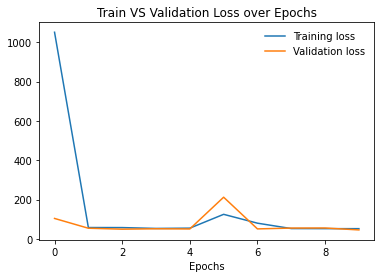

In [42]:
t = [np.mean(tloss[el]) for el in tloss]
v = [np.mean(vloss[el]) for el in vloss]

plt.plot(t, label='Training loss')
plt.plot(v, label='Validation loss')
plt.title("Train VS Validation Loss over Epochs")
plt.xlabel("Epochs")
plt.legend(frameon=False)